# Homework 5
## Alex Pine (akp258@nyu.edu)


### Question 1

Let $K_i \triangleq K\big(\frac{x_i - \bar{x}}{h}\big) $ and let $I_i \triangleq 1\{x_i \ge \bar{x}\}$. Then $1-I_i = 1\{x_i \lt \bar{x}\}$.

The pair of local linear regressions we would use in a discontinuity analysis would be:

$$ \alpha^1, \beta^1 = \displaystyle\min_{\alpha^1, \beta^1}\sum_{i} K_i I_i (y_i - \alpha^1 - \beta^1 x_i)^2 $$
and
$$ \alpha^0, \beta^0 = \displaystyle\min_{\alpha^0, \beta^0}\sum_{i} K_i (1-I_i) (y_i - \alpha^0 - \beta^0 x_i)^2 $$

The values for $ \alpha^1, \beta^1, \alpha^0, \beta^0 $ that results from these two minimization expressions will also result from their sum:

$$ \alpha^0, \beta^0, \alpha^1, \beta^1 = \displaystyle\min_{\alpha^0, \beta^0, \alpha^1, \beta^1} \sum_{i} K_i I_i (y_i - \alpha^1 - \beta^1 x_i)^2 + \sum_{i} K_i (1-I_i) (y_i - \alpha^0 - \beta^0 x_i)^2$$

Collecting terms, we get

$$ \alpha^0, \beta^0, \alpha^1, \beta^1 = \displaystyle\min_{\alpha^0, \beta^0, \alpha^1, \beta^1} \sum_{i} K_i \big( I_i (y_i - \alpha^1 - \beta^1 x_i)^2 + (1-I_i) (y_i - \alpha^0 - \beta^0 x_i)^2 \big) $$

Let's call the expression in the big parantheses $C_i$:

$$ C_i \triangleq I_i (y_i - \alpha^1 - \beta^1 x_i)^2 + (1-I_i) (y_i - \alpha^0 - \beta^0 x_i)^2 $$

If $I_i = 1$, then $ C_i = (y_i - \alpha^1 - \beta^1 x_i)^2 $. If $I_i = 0$, then $ C_i = (y_i - \alpha^0 - \beta^0 x_i)^2 $.

Let's define a new expression $D_i$:

$$ D_i \triangleq (y_i - \alpha^1 I_i - \beta^1 x_i I_i - \alpha^0 I_i - \beta^0 x_i I_i)^2 $$

Notice that if $I_i = 1$, then $ D_i = (y_i - \alpha^1 - \beta^1 x_i)^2 $, and if $I_i = 0$, $ D_i = (y_i - \alpha^0 - \beta^0 x_i)^2 $. Therefore $D_i = C_i$. This means that our original expression for $ \alpha^0, \beta^0, \alpha^1, \beta^1$ is equal to:

$$ \alpha^0, \beta^0, \alpha^1, \beta^1 = \displaystyle\min_{\alpha^0, \beta^0, \alpha^1, \beta^1} \sum_{i} K_i \big(y_i - \alpha^1 I_i - \beta^1 x_i I_i - \alpha^0 I_i - \beta^0 x_i I_i \big)^2 $$

This is what we were trying to show. QED.

## Problem 2

The data we're intested in is the total number of teachers who attended school each day of the month.
I'm making two local linear regressions. The 'left' regression where we treat the 31st as the $\bar{x}$, and the 'right' regression is where we treat the 1st of the moth as $\bar{x}$.

First, I'll graph this data without doing any regression:

In [6]:
data = "/Users/pinesol/causal/hw5/HannaDufloRyan.csv"

import pandas
df = pandas.read_csv(data)

In [11]:
# remove holiday rows
df = df[df.holiday != 1]
days = df.day
worked = df.worked

In [15]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [38]:
days_worked = df.groupby(['day'])['worked'].sum()

Doubling this data clearly shows the discontinuity between the end and first of the month (the zero value):

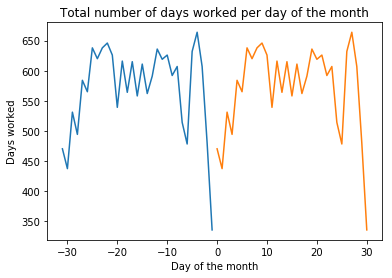

In [371]:
plt.plot(days-32, days_worked)
plt.plot(days-1, days_worked)
plt.xlabel('Day of the month')
plt.ylabel('Days worked')
plt.title('Total number of days worked per day of the month')

Next, I'll make the 'right' regression, where we don't consider points from the previous month in the regression. I'll use a bandwidth of 4, as specified in the problem. Instead of modifying the Gaussian kernel to consider the first of the month as the zero point, I'll equivalently shift over the day intercepts by one, so the 1st of the month is 0, the second day is 1, etc.

In [364]:
import statsmodels.api as sm
import math

def kernel(z):
    return math.exp(-(z*z)/2)

bandwidth = 4

In [365]:
right_days = days - 1
X = right_days
X = sm.add_constant(X)
Y = days_worked

right_weights = [kernel((x)/bandwidth) for x in X[:,1]]
right_model = sm.WLS(Y, X, weights=right_weights).fit()

In [366]:
right_intercept = right_model.params[0]
right_intercept

456.80451026081948

As shown above, the 0-intercept for the right regression is 456.8.

Now I will do the 'left' regression, where we consider all the data points to have come from before the first of the month. Since the 31st is the last day of the month, it gets set to -1, the 30th to -2, etc.

In [367]:
left_days = days - 32

X = left_days
X = sm.add_constant(X)
Y = worked
weights = [kernel((x)/bandwidth) for x in X[:,1]]
left_model = sm.WLS(Y, X, weights=weights).fit()

In [368]:
left_intercept = left_model.params[0]
left_intercept

417.91360472412623

The zero intercept of the left regression is 417.9.

The difference between zero intercepts of the right and left regression estimates the effect of the discontinuity.

In [369]:
right_intercept - left_intercept

38.890905536693253

The difference between the two intercepts is about 38.9.

I plot the data and the two regressions below to illustrate the two models:

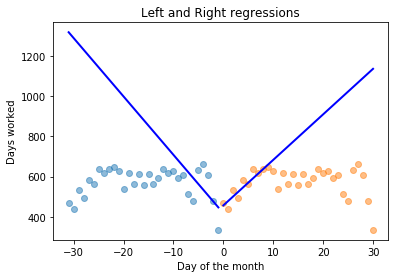

In [370]:
right_line = right_model.params[0] + right_days*right_model.params[1]
left_line = left_model.params[0] + left_days*left_model.params[1]

plt.plot(left_days, worked, 'o', alpha=0.5, label='Data')
plt.plot(right_days, days_worked, 'o', alpha=0.5, label='Data')
plt.plot(left_days, left_line, 'b', linewidth=2)
plt.plot(right_days, right_line, 'b', linewidth=2)
plt.xlabel('Day of the month')
plt.ylabel('Days worked')
plt.title('Left and Right regressions')